# 4장: 심층 합성곱 GAN (DCGAN)

- 2016년 개발
- 배치 정규화를 통해서, 각층의 입력을 정규화 하여 안정적인 훈련이 가능하게 도움
  - 2015년 구글 세르게이 이오페와 치리슈티언 세게지가 소개
  - 각 미니 배치에서 평균과 분산으로 배치 데이터 스케일 조절하여 공변량 변화(역전파에서 의해 입력의 분포가 다양하게 변경되 학습이 불완전하게 하는 문제)를 해결함.

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/gans-in-action/blob/master/chapter-4/Chapter_4_DCGAN.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩에서 실행하기</a>
  </td>
</table>

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Activation, BatchNormalization, Dense, Dropout, Flatten, Reshape
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [ ]:
img_rows = 28
img_cols = 28
channels = 1

# 입력 이미지 차원
img_shape = (img_rows, img_cols, channels)

# 생성자 입력으로 사용될 잡음 벡터의 크기
z_dim = 100

## 생성자 (가짜 만드는 놈)

In [ ]:
def build_generator(z_dim):

    model = Sequential()

    # 완전 연결층을 통해 입력을 7x7x256 크기 텐서로 변환
    model.add(Dense(256 * 7 * 7, input_dim=z_dim))
    model.add(Reshape((7, 7, 256)))

    # 전치 합성곱 <-> 일반 합성곱
    # 전치 합성곱 : 깊이를 줄이면서, 너비와 폭을 넓힌다
    # 7x7x256에서 14x14x128 텐서로 바꾸는 전치 합성곱 층
    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))

    # 배치 정규화
    model.add(BatchNormalization())

    # LeakyReLU 활성화 함수
    model.add(LeakyReLU(alpha=0.01))

    # 14x14x128에서 14x14x64 텐서로 바꾸는 전치 합성곱 층
    model.add(Conv2DTranspose(64, kernel_size=3, strides=1, padding='same'))

    # 배치 정규화
    model.add(BatchNormalization())

    # LeakyReLU 활성화 함수
    model.add(LeakyReLU(alpha=0.01))

    # 14x14x64에서 28x28x1 텐서로 바꾸는 전치 합성곱 층
    model.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same'))

    # tanh 활성화 함수를 사용한 출력층
    model.add(Activation('tanh'))

    return model

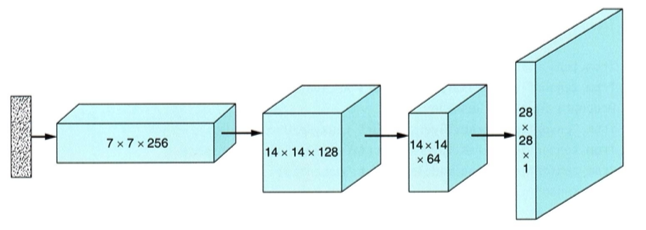

In [ ]:
from IPython.display import Image
Image('/content/drive/MyDrive/센텀수업/마지막날/GAN_생성자.png')

- 제일 왼쪽 그림은 잡음, 이미지가 결국 하나의 형태로 만드는 작업
이것을 반대로 하는 작업을 전치 합성곱이라고 한다. -> Conv2DTranspose

## 판별자 (가짜와 진짜를 판별)

In [ ]:
def build_discriminator(img_shape):

    model = Sequential()

    # 28x28x1에서 14x14x32 텐서로 바꾸는 합성곱 층
    model.add(
        Conv2D(32,
               kernel_size=3,
               strides=2,
               input_shape=img_shape,
               padding='same'))

    # LeakyReLU 활성화 함수
    model.add(LeakyReLU(alpha=0.01))

    # 14x14x32에서 7x7x64 텐서로 바꾸는 합성곱 층
    model.add(
        Conv2D(64,
               kernel_size=3,
               strides=2,
               padding='same'))

    # LeakyReLU 활성화 함수
    model.add(LeakyReLU(alpha=0.01))

    # 7x7x64에서 3x3x128 텐서로 바꾸는 합성곱 층
    model.add(
        Conv2D(128,
               kernel_size=3,
               strides=2,
               padding='same'))

    # LeakyReLU 활성화 함수
    model.add(LeakyReLU(alpha=0.01))
    
    # sigmoid 활성화 함수를 사용한 출력층
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    # 1-> 진짜인가 가짜인가 확인하는 것(이것만 한다)

    return model

- 배치 정규화를 GAN에서 필수로 사용하게 된다 -> Gan의 기본전략

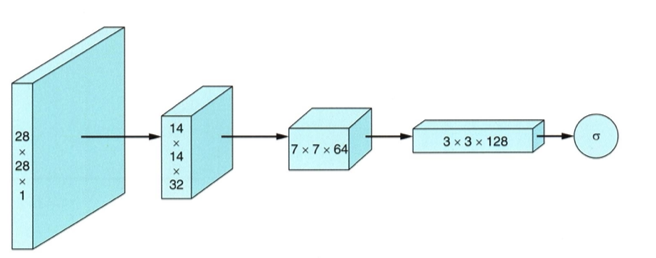

In [ ]:
Image('/content/drive/MyDrive/센텀수업/마지막날/GAN_판별자.png')

## 모델 만들기 (연결시킨 놈)

In [ ]:
def build_gan(generator, discriminator):

    model = Sequential()

    # 생성자 -> 판별자로 연결된 모델
    model.add(generator)
    model.add(discriminator)

    return model

In [ ]:
# 판별자 모델을 만들고 컴파일하기
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(),
                      metrics=['accuracy'])

# 생성자 모델 만들기
generator = build_generator(z_dim)

# 생성자를 훈련하는 동안 판별자의 파라미터를 유지 (판별자는 학습을 시키지 않는 구조)
discriminator.trainable = False

# 생성자를 훈련하기 위해 동결된 판별자로 GAN 모델을 만들고 컴파일
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

## 훈련

In [ ]:
losses = []
accuracies = []
iteration_checkpoints = []


def train(iterations, batch_size, sample_interval):

    # MNIST 데이터셋 로드
    (X_train, _), (_, _) = mnist.load_data()

    # [0, 255] 흑백 픽셀 값을 [-1, 1] 사이로 스케일 조정 (특이점)
    X_train = X_train / 127.5 - 1.0
    # ()
    X_train = np.expand_dims(X_train, axis=3)

    # 진짜 이미지 레이블: 모두 1
    real = np.ones((batch_size, 1))

    # 가짜 이미지 레이블: 모두 0
    fake = np.zeros((batch_size, 1))

    for iteration in range(iterations): # 전통적인 FIT을 사용하지 않고 for문을 통해서 2만번 돌림.

        # -------------------------
        #  판별자 훈련
        # -------------------------

        # 진짜 이미지에서 랜덤 배치 가져오기
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        # 가짜 이미지 배치 생성
        z = np.random.normal(0, 1, (batch_size, 100)) # 잠재백터
        gen_imgs = generator.predict(z)

        # 판별자 훈련
        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        # 2개의 손실의 평균, 정확도 평균
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  생성자 훈련
        # ---------------------

        # 가짜 이미지 배치 생성
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        # 생성자 훈련
        g_loss = gan.train_on_batch(z, real)

        if (iteration + 1) % sample_interval == 0:

            # 훈련이 끝난 후 그래프를 그리기 위해 손실과 정확도 저장
            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)

            # 훈련 과정 출력
            print("%d [D 손실: %f, 정확도: %.2f%%] [G 손실: %f]" %
                  (iteration + 1, d_loss, 100.0 * accuracy, g_loss))

            # 생성된 이미지 샘플 출력
            sample_images(generator)

In [ ]:
def sample_images(generator, image_grid_rows=4, image_grid_columns=4):

    # 랜덤한 잡음 샘플링
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

    # 랜덤한 잡음에서 이미지 생성하기
    gen_imgs = generator.predict(z)

    # 이미지 픽셀 값을 [0, 1] 사이로 스케일 조정
    gen_imgs = 0.5 * gen_imgs + 0.5

    # 이미지 그리드 설정
    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(4, 4),
                            sharey=True,
                            sharex=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # 이미지 그리드 출력
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    plt.show()

## GAN 훈련과 출력 점검

11501568/11490434 [==============================] - 0s 0us/step
1000 [D 손실: 0.277250, 정확도: 90.62%] [G 손실: 2.718252]


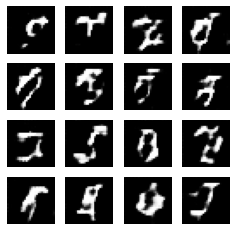

2000 [D 손실: 0.355702, 정확도: 84.77%] [G 손실: 2.348077]


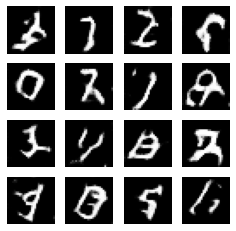

3000 [D 손실: 0.361273, 정확도: 84.77%] [G 손실: 2.168023]


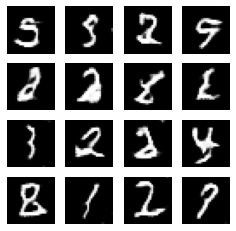

4000 [D 손실: 0.338696, 정확도: 85.16%] [G 손실: 2.483132]


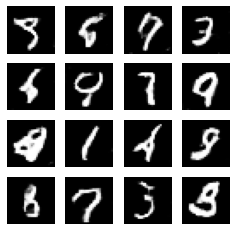

5000 [D 손실: 0.371908, 정확도: 83.20%] [G 손실: 2.092003]


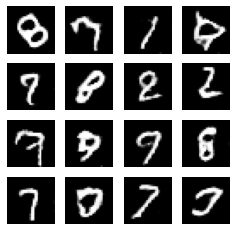

6000 [D 손실: 0.361841, 정확도: 83.20%] [G 손실: 2.247129]


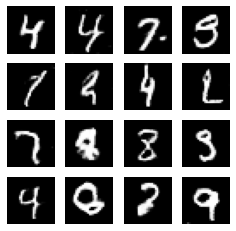

7000 [D 손실: 0.406287, 정확도: 78.91%] [G 손실: 2.087951]


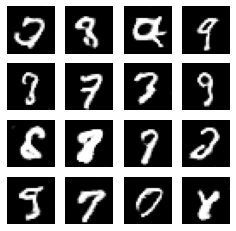

8000 [D 손실: 0.399239, 정확도: 82.42%] [G 손실: 2.216540]


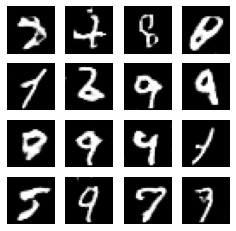

9000 [D 손실: 0.370092, 정확도: 82.81%] [G 손실: 3.069639]


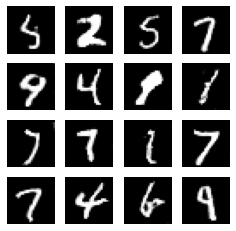

10000 [D 손실: 0.372731, 정확도: 83.20%] [G 손실: 2.391914]


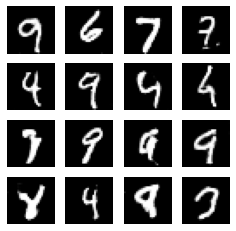

11000 [D 손실: 0.334215, 정확도: 83.98%] [G 손실: 2.268951]


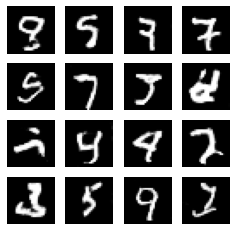

12000 [D 손실: 0.345932, 정확도: 85.55%] [G 손실: 2.051682]


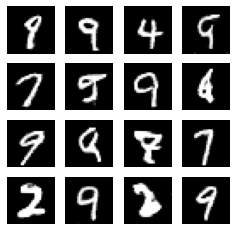

13000 [D 손실: 0.333337, 정확도: 83.20%] [G 손실: 2.245121]


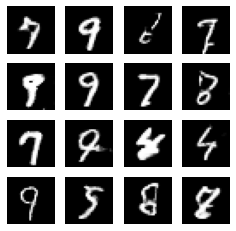

14000 [D 손실: 0.336658, 정확도: 84.77%] [G 손실: 2.360292]


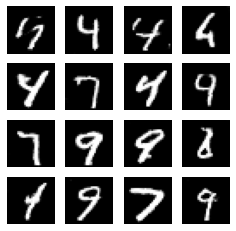

15000 [D 손실: 0.319044, 정확도: 82.42%] [G 손실: 2.373025]


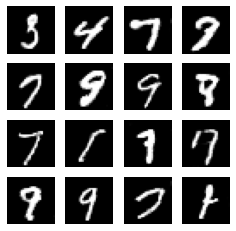

16000 [D 손실: 0.274971, 정확도: 88.28%] [G 손실: 2.605805]


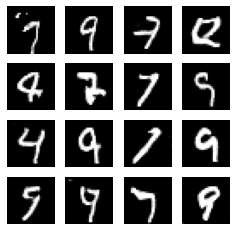

17000 [D 손실: 0.248481, 정확도: 87.11%] [G 손실: 2.544200]


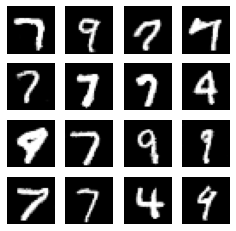

18000 [D 손실: 0.237184, 정확도: 90.23%] [G 손실: 2.349765]


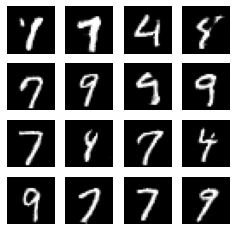

19000 [D 손실: 0.219620, 정확도: 91.80%] [G 손실: 2.057198]


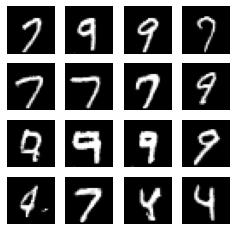

20000 [D 손실: 0.248006, 정확도: 91.02%] [G 손실: 2.076998]


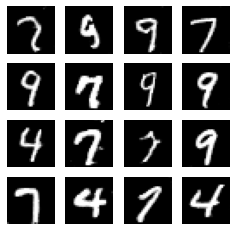

In [ ]:
# 하이퍼파라미터 설정
iterations = 20000
batch_size = 128
sample_interval = 1000

# 지정된 반복 횟수만큼 DCGAN 훈련
import tensorflow as tf
with tf.device('/device:GPU:0'):
  train(iterations, batch_size, sample_interval)

1000 [D 손실: 0.348182, 정확도: 86.33%] [G 손실: 1.762728]


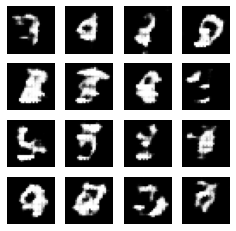

2000 [D 손실: 0.704348, 정확도: 61.72%] [G 손실: 1.109834]


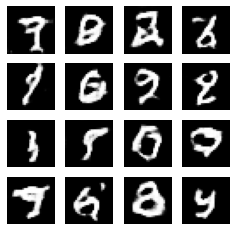

3000 [D 손실: 0.453293, 정확도: 79.69%] [G 손실: 1.620378]


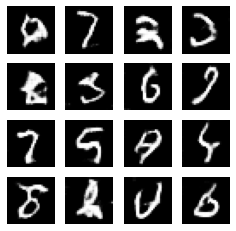

4000 [D 손실: 0.342183, 정확도: 87.50%] [G 손실: 1.834885]


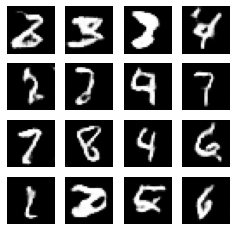

5000 [D 손실: 0.435538, 정확도: 79.69%] [G 손실: 1.645906]


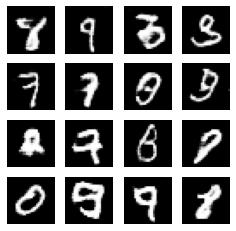

6000 [D 손실: 0.402047, 정확도: 83.20%] [G 손실: 1.606739]


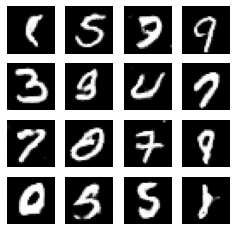

7000 [D 손실: 0.429318, 정확도: 78.12%] [G 손실: 1.473172]


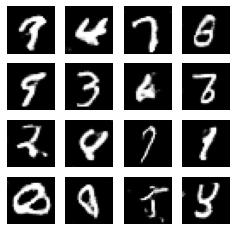

8000 [D 손실: 0.416707, 정확도: 80.47%] [G 손실: 1.765788]


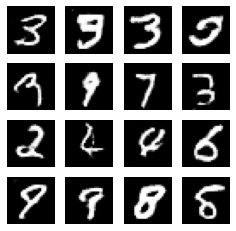

9000 [D 손실: 0.465709, 정확도: 76.95%] [G 손실: 1.672334]


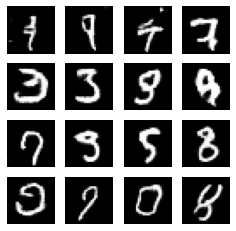

10000 [D 손실: 0.436827, 정확도: 80.08%] [G 손실: 1.754273]


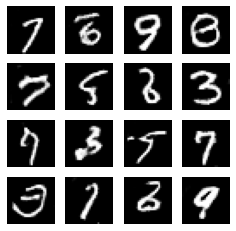

11000 [D 손실: 0.468831, 정확도: 73.44%] [G 손실: 1.679015]


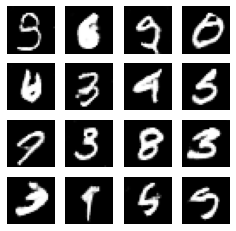

12000 [D 손실: 0.384697, 정확도: 82.81%] [G 손실: 1.901159]


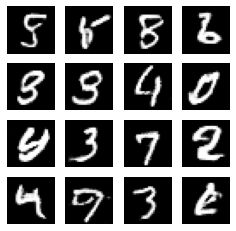

13000 [D 손실: 0.429410, 정확도: 80.86%] [G 손실: 1.783544]


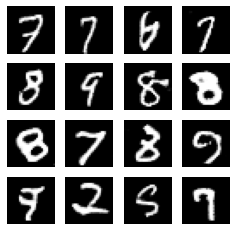

14000 [D 손실: 0.404366, 정확도: 82.03%] [G 손실: 1.996539]


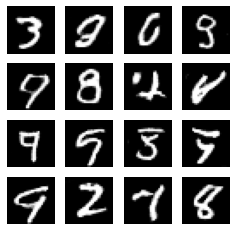

15000 [D 손실: 0.413498, 정확도: 80.86%] [G 손실: 1.837390]


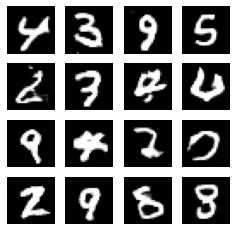

16000 [D 손실: 0.426603, 정확도: 77.73%] [G 손실: 1.736493]


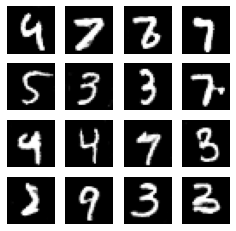

17000 [D 손실: 0.401269, 정확도: 80.47%] [G 손실: 1.580676]


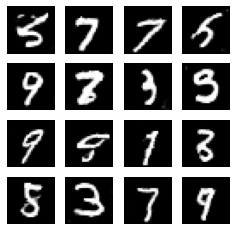

18000 [D 손실: 0.391083, 정확도: 84.38%] [G 손실: 2.087146]


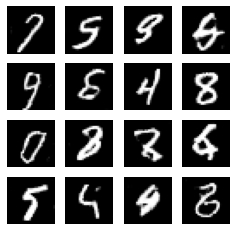

19000 [D 손실: 0.411489, 정확도: 80.47%] [G 손실: 1.972315]


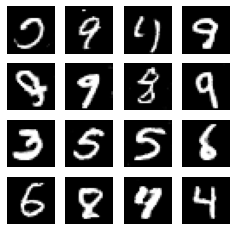

20000 [D 손실: 0.361344, 정확도: 82.42%] [G 손실: 1.858920]


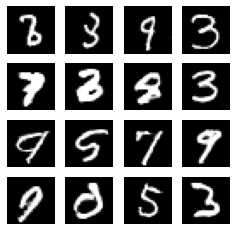

In [ ]:
# 하이퍼파라미터 설정
iterations = 20000
batch_size = 128
sample_interval = 1000

# 지정된 반복 횟수만큼 DCGAN 훈련
train(iterations, batch_size, sample_interval)

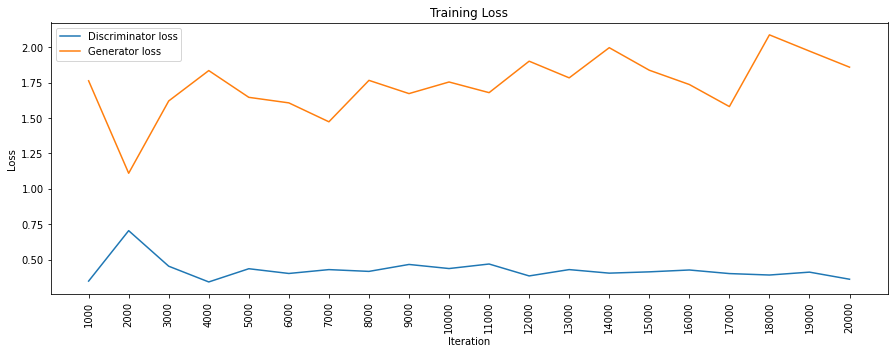

In [ ]:
losses = np.array(losses)

# 판별자와 생성자의 훈련 손실 그래프
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, losses.T[0], label="Discriminator loss")
plt.plot(iteration_checkpoints, losses.T[1], label="Generator loss")

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

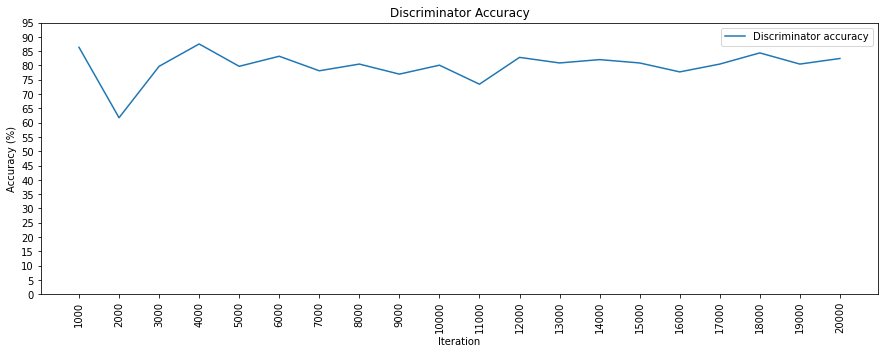

In [ ]:
accuracies = np.array(accuracies)

# 판별자의 정확도 그래프
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, accuracies, label="Discriminator accuracy")

plt.xticks(iteration_checkpoints, rotation=90)
plt.yticks(range(0, 100, 5))

plt.title("Discriminator Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy (%)")
plt.legend()